In [ ]:
# default_exp data.metadatasets

# Metadatasets: a dataset of datasets

> This functionality will allow you to create a dataset from data stores in multiple, smaller datasets.

* I'd like to thank Xander Dunn and Thomas Capelle for the work they've done to make this possible. 
* This functionality allows you to use multiple numpy arrays instead of a single one, which may be very useful in many practical settings. I've tested it with 10k+ datasets and it works well. 

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *
from tsai.data.core import *

In [ ]:
#export
class TSMetaDataset():
    " A dataset capable of indexing mutiple datasets at the same time!"
    def __init__(self, dataset_list, **kwargs):
        if not is_listy(dataset_list): dataset_list = [dataset_list]
        self.datasets = dataset_list
        self.split = kwargs['split'] if 'split' in kwargs else None            
        self.mapping = self._mapping()
        if hasattr(dataset_list[0], 'loss_func'): 
            self.loss_func =  dataset_list[0].loss_func
        else: 
            self.loss_func = None

    def __len__(self):
        if self.split is not None: 
            return len(self.split)
        else:
            return sum([len(ds) for ds in self.datasets])

    def __getitem__(self, idx):
        if self.split is not None: idx = self.split[idx]
        idx = listify(idx)
        idxs = self.mapping[idx]
        idxs = idxs[idxs[:, 0].argsort()]
        self.mapping_idxs = idxs
        ds = np.unique(idxs[:, 0])
        b = [self.datasets[d][idxs[idxs[:, 0] == d, 1]] for d in ds]
        output = tuple(map(torch.cat, zip(*b)))
        return output

    def _mapping(self):
        lengths = [len(ds) for ds in self.datasets]
        idx_pairs = np.zeros((np.sum(lengths), 2)).astype(np.int32)
        start = 0
        for i,length in enumerate(lengths):
            if i > 0: 
                idx_pairs[start:start+length, 0] = i
            idx_pairs[start:start+length, 1] = np.arange(length)
            start += length
        return idx_pairs


class TSMetaDatasets(FilteredBase):
    def __init__(self, metadataset, splits):
        store_attr()
        self.mapping = metadataset.mapping
    def subset(self, i):
        return type(self.metadataset)(self.metadataset.datasets, split=self.splits[i])
    @property
    def train(self): 
        return self.subset(0)
    @property
    def valid(self): 
        return self.subset(1)

Let's create 3 datasets. In this case they will have different sizes.

In [ ]:
dsets = []
for i in range(3):
    size = np.random.randint(50, 150)
    X = torch.rand(size, 5, 50)
    y = torch.randint(0, 10, (size,))
    tfms = [None, TSClassification()]
    dset = TSDatasets(X, y, tfms=tfms)
    dsets.append(dset)
dsets

[(#130) [(TSTensor(vars:5, len:50), TensorCategory(0)),(TSTensor(vars:5, len:50), TensorCategory(91)),(TSTensor(vars:5, len:50), TensorCategory(28)),(TSTensor(vars:5, len:50), TensorCategory(103)),(TSTensor(vars:5, len:50), TensorCategory(92)),(TSTensor(vars:5, len:50), TensorCategory(111)),(TSTensor(vars:5, len:50), TensorCategory(8)),(TSTensor(vars:5, len:50), TensorCategory(67)),(TSTensor(vars:5, len:50), TensorCategory(42)),(TSTensor(vars:5, len:50), TensorCategory(9))...],
 (#62) [(TSTensor(vars:5, len:50), TensorCategory(46)),(TSTensor(vars:5, len:50), TensorCategory(25)),(TSTensor(vars:5, len:50), TensorCategory(8)),(TSTensor(vars:5, len:50), TensorCategory(47)),(TSTensor(vars:5, len:50), TensorCategory(9)),(TSTensor(vars:5, len:50), TensorCategory(57)),(TSTensor(vars:5, len:50), TensorCategory(60)),(TSTensor(vars:5, len:50), TensorCategory(26)),(TSTensor(vars:5, len:50), TensorCategory(27)),(TSTensor(vars:5, len:50), TensorCategory(35))...],
 (#129) [(TSTensor(vars:5, len:50), 

In [ ]:
metadataset = TSMetaDataset(dsets)
metadataset

We'll apply splits now to create train and valid metadatasets: 

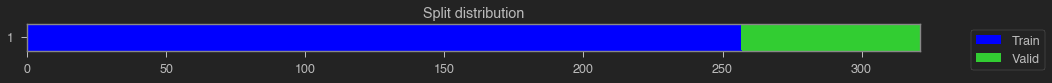

((#257) [0,1,2,3,4,5,6,7,8,9...],
 (#64) [257,258,259,260,261,262,263,264,265,266...])

In [ ]:
splits = TimeSplitter()(metadataset)
splits

In [ ]:
metadatasets = TSMetaDatasets(metadataset, splits=splits)
metadatasets.train, metadatasets.valid

(<__main__.TSMetaDataset at 0x7fa7612d9d50>,
 <__main__.TSMetaDataset at 0x7fa7612d9c50>)

In [ ]:
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)
xb, yb = first(dls.train)
xb, yb

(TSTensor(samples:64, vars:5, len:50),
 TensorCategory([ 89, 128,  69,  34,  47, 117,  33,  67,  82,  95,  45,  97,  43,  52,
          30,  17, 126,  22,  57, 114,  14,  54,  41,  65,  94,   0, 112,  55,
          45,  40,  50,   6,  46,  26,  27,  10,   9,  52,  11,  43,  57,  32,
          24,  21,  39,  84,  12,  56,  87,  13,  34,  24,  32, 106,  52,  82,
          11,  88,  22,   1,  20,  85,  55,  43]))

There also en easy way to map any particular sample in a batch to the original dataset and id: 

In [ ]:
dls = TSDataLoaders.from_dsets(metadatasets.train, metadatasets.valid)
xb, yb = first(dls.train)
mappings = dls.train.dataset.mapping_idxs
for i, (xbi, ybi) in enumerate(zip(xb, yb)):
    ds, idx = mappings[i]
    test_close(dsets[ds][idx][0].data, xbi)
    test_close(dsets[ds][idx][1].data, ybi)

For example the 3rd sample in this batch would be: 

In [ ]:
dls.train.dataset.mapping_idxs[2]

array([  0, 123], dtype=int32)

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002_data.metadatasets.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 008b_tslearner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.MVP.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.Res